# Intro Task, Object Localization 

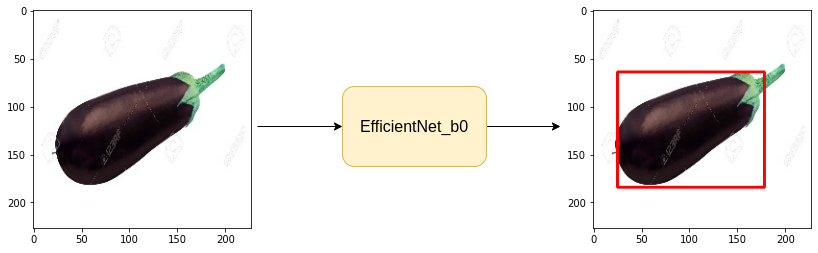

In [50]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-j7_moojv
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-j7_moojv
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

fatal: destination path 'object-localization-dataset' already exists and is not an empty directory.


In [52]:
!nvidia-smi

Tue Jul  5 05:14:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    34W / 250W |   1035MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [53]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [54]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [55]:
csv_file ='/content/object-localization-dataset/train.csv'
data_dir = '/content/object-localization-dataset/'

device = 'cuda'

batch_size = 16
img_size =140

lr=0.001
epochs=40
model_name='efficientnet_b0'

num_cor = 4

In [56]:
df = pd.read_csv(csv_file)

In [57]:
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

In [58]:
row = df.iloc[100]

In [59]:
row

img_path    train_images/eggplant_13.jpg
xmin                                  25
ymin                                  64
xmax                                 178
ymax                                 184
width                                227
height                               227
label                           eggplant
Name: 100, dtype: object

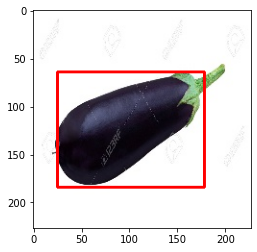

In [60]:
img = cv2.imread(data_dir+row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1= (row.xmin,row.ymin)
pt2 = (row.xmax,row.ymax)
bnd_box_img = cv2.rectangle(img,pt1,pt2,(255,0,0),2)
plt.imshow(img)

In [61]:
train_df, valid_df = train_test_split(df,test_size=0.20,random_state=42)

# Augmentations

In [62]:
import albumentations as A

In [63]:
from albumentations.core.composition import BboxParams
from albumentations.augmentations.transforms import VerticalFlip
train_augs = A.Compose([
                        A.Resize(img_size,img_size),
                        A.HorizontalFlip(p=0.5),
                        A.VerticalFlip(p=0.5),
                        A.Rotate()
],bbox_params=A.BboxParams(format='pascal_voc', label_fields= ['class_labels']))

valid_augs= A.Compose([
                       A.Resize(img_size,img_size),
],bbox_params=A.BboxParams(format='pascal_voc', label_fields= ['class_labels']))


# Create Custom Dataset

In [64]:
class ObjLocDataset(torch.utils.data.Dataset):

  def __init__(self,df,augmentations = None):
    self.df = df
    self.augmentations = augmentations
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    bbox = [[xmin,ymin,xmax,ymax]]

    img_path = data_dir + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img, bboxes=bbox,class_labels = [None])
      img = data['image']
      bbox=data['bboxes'][0]

    img = torch.from_numpy(img).permute(2,0,1)/255.0 # (h,w,c) ->(c,h,w)
    bbox= torch.Tensor(bbox)

    return img, bbox


In [65]:
trainset = ObjLocDataset(train_df,train_augs)
validset = ObjLocDataset(valid_df,valid_augs)

In [66]:
print("total example in train",{len(trainset)})
print("total example in valid",{len(validset)})

total example in train {148}
total example in valid {38}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


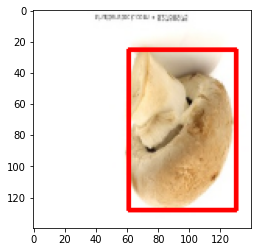

In [67]:
img, bbox = trainset[100]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [68]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size,shuffle= True)
validloader = torch.utils.data.DataLoader(validset, batch_size = batch_size,shuffle= True)

In [69]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [70]:
for images, bboxes in trainloader:
  break;


print("Shape of one batch images : {}".format(images.shape))# batch size color chinal piecture size
print("Shape of one batch bboxes : {}".format(bboxes.shape))# xy max min

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [71]:
from torch import nn 
import timm

In [72]:
model_name

'efficientnet_b0'

In [73]:
class ObjLocModel(nn.Module):

  def __init__(self):

    super(ObjLocModel,self).__init__()

    self.backbone = timm.create_model(model_name,pretrained = True, num_classes=4) # logic output

  def forward(self, images, gt_bboxes = None):

    
    bboxes = self.backbone(images)

    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes,gt_bboxes)
      return bboxes, loss

    return bboxes

In [74]:
model = ObjLocModel()
model.to(device);

In [75]:

# random_img = torch.rand(1,3,140,140).to(device)
# model(random_img).shape
random_img = torch.rand(1,3,140,140).to(device)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [76]:
def train_fn(model, dataloader, optimizer):
  total_loss = 0.0
  model.train()

  for data in tqdm(dataloader):
    images, gt_bboxes = data
    images, gt_bboxes = images.to(device),gt_bboxes.to(device)

    bboxes, loss = model(images,gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss/len(dataloader)


In [77]:
def eval_fn(model, dataloader):
  total_loss = 0.0
  model.eval() # dropout

  with torch.no_grad():
    for data in tqdm(dataloader):
      images, gt_bboxes = data
      images, gt_bboxes = images.to(device),gt_bboxes.to(device)

      bboxes, loss = model(images,gt_bboxes)

      total_loss += loss.item()
    return total_loss/len(dataloader)

#Training Loop

In [78]:
from inspect import Parameter
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [79]:
best_valid_loss = np.Inf

for i in range(epochs):
  train_loss = train_fn(model,trainloader,optimizer)
  valid_loss = eval_fn(model,validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print("weights- are saved")
    best_valid_loss = valid_loss

  print(f"Epoch:{i+1}train loss: {train_loss} valid loss:{valid_loss}")


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights- are saved
Epoch:1train loss: 5258.790966796875 valid loss:9569.8349609375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights- are saved
Epoch:2train loss: 2093.268591308594 valid loss:2297.3019205729165


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights- are saved
Epoch:3train loss: 1180.5425842285156 valid loss:393.3463948567708


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights- are saved
Epoch:4train loss: 735.6141418457031 valid loss:228.53087870279947


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights- are saved
Epoch:5train loss: 565.5412231445313 valid loss:176.43123372395834


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:6train loss: 438.20339050292966 valid loss:206.52562459309897


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:7train loss: 287.0536407470703 valid loss:280.1930847167969


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:8train loss: 236.3034423828125 valid loss:217.67205810546875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights- are saved
Epoch:9train loss: 163.60338897705077 valid loss:166.09835815429688


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights- are saved
Epoch:10train loss: 136.53377151489258 valid loss:141.47317250569662


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights- are saved
Epoch:11train loss: 140.5045249938965 valid loss:125.45141347249348


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:12train loss: 126.32061920166015 valid loss:155.33318074544272


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights- are saved
Epoch:13train loss: 107.071484375 valid loss:115.51721954345703


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:14train loss: 93.34330558776855 valid loss:124.45360310872395


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights- are saved
Epoch:15train loss: 113.40550727844239 valid loss:111.90370178222656


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights- are saved
Epoch:16train loss: 87.75272331237792 valid loss:102.5357157389323


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights- are saved
Epoch:17train loss: 79.97491912841797 valid loss:89.56798807779948


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights- are saved
Epoch:18train loss: 61.54009666442871 valid loss:77.06135686238606


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:19train loss: 54.31287803649902 valid loss:82.03305562337239


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:20train loss: 52.06042194366455 valid loss:79.93199157714844


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:21train loss: 70.94832420349121 valid loss:77.82894897460938


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:22train loss: 49.513915634155275 valid loss:84.30625915527344


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights- are saved
Epoch:23train loss: 48.1967170715332 valid loss:76.99162292480469


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:24train loss: 41.09431037902832 valid loss:84.85700225830078


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights- are saved
Epoch:25train loss: 49.21308708190918 valid loss:61.97135543823242


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights- are saved
Epoch:26train loss: 54.520415496826175 valid loss:50.72917811075846


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:27train loss: 54.7118616104126 valid loss:73.62549082438152


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:28train loss: 40.57446212768555 valid loss:71.32132466634114


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:29train loss: 40.02212924957276 valid loss:63.60958671569824


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:30train loss: 52.06443462371826 valid loss:62.968268076578774


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:31train loss: 55.146626472473145 valid loss:70.12920633951823


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:32train loss: 50.65188484191894 valid loss:74.3067626953125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:33train loss: 43.42525215148926 valid loss:94.01735432942708


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:34train loss: 52.76679630279541 valid loss:80.13029352823894


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:35train loss: 43.26784191131592 valid loss:84.16039784749348


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:36train loss: 35.15334644317627 valid loss:62.30145009358724


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:37train loss: 35.34989585876465 valid loss:71.16908137003581


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:38train loss: 41.20586013793945 valid loss:60.16156514485677


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:39train loss: 46.41185131072998 valid loss:54.29129727681478


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:40train loss: 35.69998073577881 valid loss:62.30280558268229


#Inference

In [81]:
import utils

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


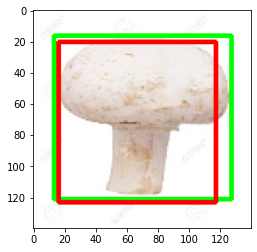

In [82]:
model.load_state_dict(torch.load('best_model.pt'))

with torch.no_grad():
  image, gt_bboxes = validset[1] # (c,h,w)
  image = image.unsqueeze(0).to(device) # (bs,c,g,w)
  out_bbox = model(image)

  utils.compare_plots(image,gt_bboxes,out_bbox)